## Imports and Data Preprocessing

Import data and do basics of removing extraneous data

In [1]:
# Initial imports
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import np_utils
%matplotlib inline

In [2]:
# Import Verlander dataset 

verlander_df = pd.read_csv(Path("../resources/verlander_update.csv"))

display(verlander_df.head())

,pitch_type,game_date,player_name,batter,pitcher,events,description,zone,des,stand,...,on_1b,outs_when_up,inning,at_bat_number,pitch_number,pitch_name,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment
0,SL,9/16/2022,"Verlander, Justin",669127,434378,strikeout,swinging_strike,9,Shea Langeliers strikes out swinging.,R,...,NaN,2,5,35,5,Slider,0,2,Infield shift,Standard
1,FF,9/16/2022,"Verlander, Justin",669127,434378,NaN,foul,3,Shea Langeliers strikes out swinging.,R,...,NaN,2,5,35,4,4-Seam Fastball,0,2,Infield shift,Standard
2,SL,9/16/2022,"Verlander, Justin",669127,434378,NaN,called_strike,13,Shea Langeliers strikes out swinging.,R,...,NaN,2,5,35,3,Slider,0,2,Infield shift,Standard
3,FF,9/16/2022,"Verlander, Justin",669127,434378,NaN,foul,1,Shea Langeliers strikes out swinging.,R,...,NaN,2,5,35,2,4-Seam Fastball,0,2,Infield shift,Standard
4,SL,9/16/2022,"Verlander, Justin",669127,434378,NaN,ball,8,Shea Langeliers strikes out swinging.,R,...,NaN,2,5,35,1,Slider,0,2,Infield shift,Standard


In [3]:
# Clean dataset 

verlander_df = verlander_df.drop(columns=['des',
'at_bat_number', 
'inning', 
'zone', 
'player_name', 
'batter', 
'pitcher', 
'events',
'bb_type',
'hit_location',
'home_team',
'away_team'])

display(verlander_df.head())

,pitch_type,game_date,description,stand,p_throws,type,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,pitch_number,pitch_name,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment
0,SL,9/16/2022,swinging_strike,R,R,S,1,2,NaN,NaN,NaN,2,5,Slider,0,2,Infield shift,Standard
1,FF,9/16/2022,foul,R,R,S,1,2,NaN,NaN,NaN,2,4,4-Seam Fastball,0,2,Infield shift,Standard
2,SL,9/16/2022,called_strike,R,R,S,1,1,NaN,NaN,NaN,2,3,Slider,0,2,Infield shift,Standard
3,FF,9/16/2022,foul,R,R,S,1,0,NaN,NaN,NaN,2,2,4-Seam Fastball,0,2,Infield shift,Standard
4,SL,9/16/2022,ball,R,R,B,0,0,NaN,NaN,NaN,2,1,Slider,0,2,Infield shift,Standard


In [4]:
# Encode 1st, 2nd and 3rd bases with 1s and 0s

# Fill NaN to 0 
verlander_df['on_3b'] = verlander_df['on_3b'].fillna(0)
verlander_df['on_2b'] = verlander_df['on_2b'].fillna(0)
verlander_df['on_1b'] = verlander_df['on_1b'].fillna(0)

# Change batter IDs to 1 
verlander_df['on_3b'][verlander_df['on_3b'] > 0.0] = 1.0
verlander_df['on_2b'][verlander_df['on_2b'] > 0.0] = 1.0
verlander_df['on_1b'][verlander_df['on_1b'] > 0.0] = 1.0

display(verlander_df.head())

/var/folders/zx/3xfmqcd54f3fdz2hfpnll0_80000gn/T/ipykernel_7440/1558983953.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verlander_df['on_3b'][verlander_df['on_3b'] > 0.0] = 1.0
/var/folders/zx/3xfmqcd54f3fdz2hfpnll0_80000gn/T/ipykernel_7440/1558983953.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verlander_df['on_2b'][verlander_df['on_2b'] > 0.0] = 1.0
/var/folders/zx/3xfmqcd54f3fdz2hfpnll0_80000gn/T/ipykernel_7440/1558983953.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,pitch_type,game_date,description,stand,p_throws,type,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,pitch_number,pitch_name,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment
0,SL,9/16/2022,swinging_strike,R,R,S,1,2,0.0,0.0,0.0,2,5,Slider,0,2,Infield shift,Standard
1,FF,9/16/2022,foul,R,R,S,1,2,0.0,0.0,0.0,2,4,4-Seam Fastball,0,2,Infield shift,Standard
2,SL,9/16/2022,called_strike,R,R,S,1,1,0.0,0.0,0.0,2,3,Slider,0,2,Infield shift,Standard
3,FF,9/16/2022,foul,R,R,S,1,0,0.0,0.0,0.0,2,2,4-Seam Fastball,0,2,Infield shift,Standard
4,SL,9/16/2022,ball,R,R,B,0,0,0.0,0.0,0.0,2,1,Slider,0,2,Infield shift,Standard


In [5]:
# Fill NaN in description column

verlander_df['description'] = verlander_df['description'].fillna('nothing')

## Feature Engineering

In [6]:
# Shift pitches so that model does not know the upcoming pitch 

verlander_df['pitch_name'] = verlander_df['pitch_name'].shift(-1).dropna()
verlander_df['type'] = verlander_df['type'].shift(-1).dropna()

display(verlander_df)

,pitch_type,game_date,description,stand,p_throws,type,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,pitch_number,pitch_name,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment
0,SL,9/16/2022,swinging_strike,R,R,S,1,2,0.0,0.0,0.0,2,5,4-Seam Fastball,0,2,Infield shift,Standard
1,FF,9/16/2022,foul,R,R,S,1,2,0.0,0.0,0.0,2,4,Slider,0,2,Infield shift,Standard
2,SL,9/16/2022,called_strike,R,R,S,1,1,0.0,0.0,0.0,2,3,4-Seam Fastball,0,2,Infield shift,Standard
3,FF,9/16/2022,foul,R,R,B,1,0,0.0,0.0,0.0,2,2,Slider,0,2,Infield shift,Standard
4,SL,9/16/2022,ball,R,R,X,0,0,0.0,0.0,0.0,2,1,Slider,0,2,Infield shift,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331,FF,4/9/2022,swinging_strike,L,R,S,2,2,0.0,0.0,0.0,0,5,4-Seam Fastball,0,0,Infield shift,Standard
2332,FF,4/9/2022,foul_tip,L,R,B,2,1,0.0,0.0,0.0,0,4,4-Seam Fastball,0,0,Infield shift,Standard
2333,FF,4/9/2022,ball,L,R,S,1,1,0.0,0.0,0.0,0,3,4-Seam Fastball,0,0,Infield shift,Standard
2334,FF,4/9/2022,called_strike,L,R,B,1,0,0.0,0.0,0.0,0,2,4-Seam Fastball,0,0,Infield shift,Standard


In [7]:
# Converting batting score and fielding score to one column.
# Positive number means fielding team is winning and negative number means batting team is winning. 
verlander_df['score_diff'] = verlander_df['fld_score'] - verlander_df['bat_score']


# Drop batting score and fielding score columns now that you have the score differential
verlander_df.drop(columns = ['bat_score', 'fld_score'])

,pitch_type,game_date,description,stand,p_throws,type,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,pitch_number,pitch_name,if_fielding_alignment,of_fielding_alignment,score_diff
0,SL,9/16/2022,swinging_strike,R,R,S,1,2,0.0,0.0,0.0,2,5,4-Seam Fastball,Infield shift,Standard,2
1,FF,9/16/2022,foul,R,R,S,1,2,0.0,0.0,0.0,2,4,Slider,Infield shift,Standard,2
2,SL,9/16/2022,called_strike,R,R,S,1,1,0.0,0.0,0.0,2,3,4-Seam Fastball,Infield shift,Standard,2
3,FF,9/16/2022,foul,R,R,B,1,0,0.0,0.0,0.0,2,2,Slider,Infield shift,Standard,2
4,SL,9/16/2022,ball,R,R,X,0,0,0.0,0.0,0.0,2,1,Slider,Infield shift,Standard,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331,FF,4/9/2022,swinging_strike,L,R,S,2,2,0.0,0.0,0.0,0,5,4-Seam Fastball,Infield shift,Standard,0
2332,FF,4/9/2022,foul_tip,L,R,B,2,1,0.0,0.0,0.0,0,4,4-Seam Fastball,Infield shift,Standard,0
2333,FF,4/9/2022,ball,L,R,S,1,1,0.0,0.0,0.0,0,3,4-Seam Fastball,Infield shift,Standard,0
2334,FF,4/9/2022,called_strike,L,R,B,1,0,0.0,0.0,0.0,0,2,4-Seam Fastball,Infield shift,Standard,0


In [8]:
# Feature engineering to count the number of pitches JV has thrown each outing

verlander_df['ones'] = 1
pitch_count_df = verlander_df[['game_date', 'ones']]
pitch_count_df['pitch_count'] = pitch_count_df.groupby(['game_date']).cumcount(ascending = False)
pitch_count_df['pitch_count'] = pitch_count_df['pitch_count'] + 1

verlander_df = pd.concat([verlander_df, pitch_count_df['pitch_count']], join='inner', axis=1)



/var/folders/zx/3xfmqcd54f3fdz2hfpnll0_80000gn/T/ipykernel_7440/40428878.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitch_count_df['pitch_count'] = pitch_count_df.groupby(['game_date']).cumcount(ascending = False)
/var/folders/zx/3xfmqcd54f3fdz2hfpnll0_80000gn/T/ipykernel_7440/40428878.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitch_count_df['pitch_count'] = pitch_count_df['pitch_count'] + 1


In [9]:
# Feature engineering to change the ball and strike count into one column as a string

verlander_df['count'] = verlander_df['balls'].astype(str) +'-'+ verlander_df['strikes'].astype(str)
verlander_df.drop(columns=['balls', 'strikes'])
verlander_df.head()

,pitch_type,game_date,description,stand,p_throws,type,balls,strikes,on_3b,on_2b,...,pitch_number,pitch_name,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment,score_diff,ones,pitch_count,count
0,SL,9/16/2022,swinging_strike,R,R,S,1,2,0.0,0.0,...,5,4-Seam Fastball,0,2,Infield shift,Standard,2,1,79,1-2
1,FF,9/16/2022,foul,R,R,S,1,2,0.0,0.0,...,4,Slider,0,2,Infield shift,Standard,2,1,78,1-2
2,SL,9/16/2022,called_strike,R,R,S,1,1,0.0,0.0,...,3,4-Seam Fastball,0,2,Infield shift,Standard,2,1,77,1-1
3,FF,9/16/2022,foul,R,R,B,1,0,0.0,0.0,...,2,Slider,0,2,Infield shift,Standard,2,1,76,1-0
4,SL,9/16/2022,ball,R,R,X,0,0,0.0,0.0,...,1,Slider,0,2,Infield shift,Standard,2,1,75,0-0


## Data Processing 

Prepare data to be fed into model

In [10]:
# Split into X and y 

X = verlander_df.drop(columns=['pitch_type', 'game_date'])
y= verlander_df['pitch_type']

display(y.value_counts)

<bound method IndexOpsMixin.value_counts of 0       SL
1       FF
2       SL
3       FF
4       SL
        ..
2331    FF
2332    FF
2333    FF
2334    FF
2335    FF
Name: pitch_type, Length: 2336, dtype: object>

In [11]:
# Use get_dummies to encode categorical variables 

X = pd.get_dummies(X)

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)

display(X.head())
display(dummy_y)

display(X.columns)

# SL = index 3
# CH = index 0
# FF = index 2
# CU = index 1

,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,pitch_number,bat_score,fld_score,score_diff,...,count_0-2,count_1-0,count_1-1,count_1-2,count_2-0,count_2-1,count_2-2,count_3-0,count_3-1,count_3-2
0,1,2,0.0,0.0,0.0,2,5,0,2,2,...,0,0,0,1,0,0,0,0,0,0
1,1,2,0.0,0.0,0.0,2,4,0,2,2,...,0,0,0,1,0,0,0,0,0,0
2,1,1,0.0,0.0,0.0,2,3,0,2,2,...,0,0,1,0,0,0,0,0,0,0
3,1,0,0.0,0.0,0.0,2,2,0,2,2,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0.0,0.0,0.0,2,1,0,2,2,...,0,0,0,0,0,0,0,0,0,0


array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

Index(['balls', 'strikes', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up',
       'pitch_number', 'bat_score', 'fld_score', 'score_diff', 'ones',
       'pitch_count', 'description_ball', 'description_blocked_ball',
       'description_called_strike', 'description_foul',
       'description_foul_bunt', 'description_foul_tip',
       'description_hit_by_pitch', 'description_hit_into_play',
       'description_swinging_strike', 'description_swinging_strike_blocked',
       'stand_L', 'stand_R', 'p_throws_R', 'type_B', 'type_S', 'type_X',
       'pitch_name_4-Seam Fastball', 'pitch_name_Changeup',
       'pitch_name_Curveball', 'pitch_name_Slider',
       'if_fielding_alignment_Infield shift', 'if_fielding_alignment_Standard',
       'if_fielding_alignment_Strategic', 'of_fielding_alignment_Standard',
       'of_fielding_alignment_Strategic', 'count_0-0', 'count_0-1',
       'count_0-2', 'count_1-0', 'count_1-1', 'count_1-2', 'count_2-0',
       'count_2-1', 'count_2-2', 'count_3-0', 'count_3-

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, random_state=1)

## Deep Learning/Neural Network Architecture

Using the method from the module, the following basis is used to design the first iteration of the neural network: 

*the mean of the number of input features and the number of neurons in the output layer ((number of input features + number of neurons in output layer) / 2). Use a number close to this mean for the number of neurons in the first hidden layer. Repeat this pattern for subsequent hidden layers ((number of neurons in the prior hidden layer + number of neurons in output layer) / 2). Softmax is the activation for the output layer that is used for multi-class classification. Categorial cross entropy and predictive model accuracy are respectively the loss functions and metrics used for multi-class classification*

In [13]:
# Initialize the Deep Learning Neural Network model

nn_v0 = Sequential()

2022-09-27 22:25:56.130609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# Design the network architecture 

# Define the model - deep neural net
number_input_features = len(X.columns)
number_output = 4

# Define hidden layers
i = 0
hidden_nodes_layer=(number_input_features+number_output)/2
while hidden_nodes_layer/2 > 4:
    if i == 0:
        nn_v0.add(Dense(units=round(hidden_nodes_layer), input_dim=number_input_features, activation='relu'))
        i+=1
    else:
        hidden_nodes_layer = hidden_nodes_layer/2
        nn_v0.add(Dense(units=round(hidden_nodes_layer), activation='relu'))
        i+=1

# Define output layer
nn_v0.add(Dense(units=number_output, activation='softmax'))

# Compile the model
nn_v0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

display(nn_v0.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 26)                1300      
                                                                 
 dense_1 (Dense)             (None, 13)                351       
                                                                 
 dense_2 (Dense)             (None, 7)                 98        
                                                                 
 dense_3 (Dense)             (None, 4)                 32        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


None

In [15]:
# Fit the data to the model

model_v0 = nn_v0.fit(X_train, y_train, epochs=100)

Epoch 1/100
55/55 [==============================] - 1s 891us/step - loss: 1.3093 - accuracy: 0.4155
Epoch 2/100
55/55 [==============================] - 0s 987us/step - loss: 1.1406 - accuracy: 0.4726
Epoch 3/100
55/55 [==============================] - 0s 912us/step - loss: 1.0995 - accuracy: 0.5097
Epoch 4/100
55/55 [==============================] - 0s 889us/step - loss: 1.0763 - accuracy: 0.5097
Epoch 5/100
55/55 [==============================] - 0s 954us/step - loss: 1.0591 - accuracy: 0.5217
Epoch 6/100
55/55 [==============================] - 0s 906us/step - loss: 1.0495 - accuracy: 0.5257
Epoch 7/100
55/55 [==============================] - 0s 998us/step - loss: 1.0364 - accuracy: 0.5360
Epoch 8/100
55/55 [==============================] - 0s 886us/step - loss: 1.0304 - accuracy: 0.5462
Epoch 9/100
55/55 [==============================] - 0s 906us/step - loss: 1.0196 - accuracy: 0.5628
Epoch 10/100
55/55 [==============================] - 0s 922us/step - loss: 1.0128 - accura

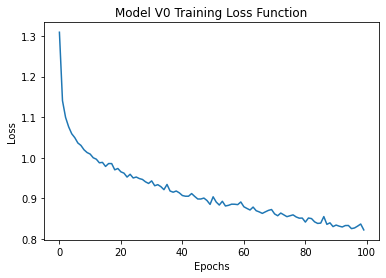

In [16]:
# Plot the loss over epochs

plt.plot(model_v0.history["loss"])
plt.title("Model V0 Training Loss Function")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

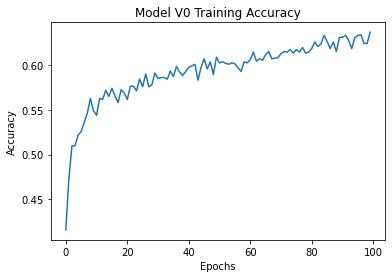

In [17]:
# Plot the accuracy over epochs

plt.plot(model_v0.history["accuracy"])
plt.title("Model V0 Training Accuracy")
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()

In [18]:
model_loss, model_accuracy = nn_v0.evaluate(
    X_test, y_test, verbose=2
)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

19/19 - 0s - loss: 1.1674 - accuracy: 0.5205 - 136ms/epoch - 7ms/step
Loss: 1.1673791408538818, Accuracy: 0.5205479264259338


In [19]:

y_pred = nn_v0.predict(X_test)
pred_final = np.argmax(y_pred, axis=1)

y_test_reverted = []
for lists in y_test:
    if lists[0] == 1:
        y_test_reverted.append('CH')
    elif lists[1] == 1:
        y_test_reverted.append('CU')
    elif lists[2] == 1:
        y_test_reverted.append('FF')
    else:
        y_test_reverted.append('SL')

y_pred_converted = []
for numbers in pred_final:
    if numbers == 0:
        y_pred_converted.append('CH')
    elif numbers == 1:
        y_pred_converted.append('CU')
    elif numbers == 2:
        y_pred_converted.append('FF')
    else: 
        y_pred_converted.append('SL')

# display(y_test)
# display(pred_final)
final_results = pd.DataFrame({
    'Predictions': y_pred_converted,
    'Actual':  y_test_reverted})

display(final_results.head())
print(classification_report(final_results['Actual'], final_results['Predictions']))


19/19 [==============================] - 0s 1ms/step


,Predictions,Actual
0,FF,FF
1,SL,FF
2,FF,FF
3,SL,FF
4,FF,CU


              precision    recall  f1-score   support

          CH       0.00      0.00      0.00         8
          CU       0.35      0.25      0.29       120
          FF       0.61      0.65      0.63       292
          SL       0.46      0.51      0.48       164

    accuracy                           0.52       584
   macro avg       0.35      0.35      0.35       584
weighted avg       0.50      0.52      0.51       584



/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Optimize the Model

### Optimized Model 1
Optimize the model by increasing the number of epochs 

In [20]:
#Define the new, optimized model

nn_v1 = Sequential()

In [21]:
# Design the network architecture 

# Define the model - deep neural net
number_input_features = len(X.columns)
number_output = 4

# Define hidden layers
i = 0
hidden_nodes_layer=(number_input_features+number_output)/2
while hidden_nodes_layer/2 > 4: 
    if i == 0:
        nn_v1.add(Dense(units=round(hidden_nodes_layer), input_dim=number_input_features, activation='relu'))
        i+=1
    else:
        hidden_nodes_layer = hidden_nodes_layer/2
        nn_v1.add(Dense(units=round(hidden_nodes_layer), activation='relu'))
        i+=1

# Define output layer
nn_v1.add(Dense(units=number_output, activation='softmax'))

# Compile the model
nn_v1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

display(nn_v1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 26)                1300      
                                                                 
 dense_5 (Dense)             (None, 13)                351       
                                                                 
 dense_6 (Dense)             (None, 7)                 98        
                                                                 
 dense_7 (Dense)             (None, 4)                 32        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


None

In [22]:
# Fit the data to the model

model_v1 = nn_v1.fit(X_train, y_train, epochs=500)

Epoch 1/500
55/55 [==============================] - 0s 886us/step - loss: 1.5991 - accuracy: 0.2209
Epoch 2/500
55/55 [==============================] - 0s 875us/step - loss: 1.2968 - accuracy: 0.4943
Epoch 3/500
55/55 [==============================] - 0s 873us/step - loss: 1.1863 - accuracy: 0.4989
Epoch 4/500
55/55 [==============================] - 0s 874us/step - loss: 1.1501 - accuracy: 0.5034
Epoch 5/500
55/55 [==============================] - 0s 855us/step - loss: 1.1137 - accuracy: 0.5103
Epoch 6/500
55/55 [==============================] - 0s 862us/step - loss: 1.0847 - accuracy: 0.5154
Epoch 7/500
55/55 [==============================] - 0s 872us/step - loss: 1.0613 - accuracy: 0.5291
Epoch 8/500
55/55 [==============================] - 0s 853us/step - loss: 1.0454 - accuracy: 0.5314
Epoch 9/500
55/55 [==============================] - 0s 2ms/step - loss: 1.0387 - accuracy: 0.5474
Epoch 10/500
55/55 [==============================] - 0s 895us/step - loss: 1.0261 - accuracy

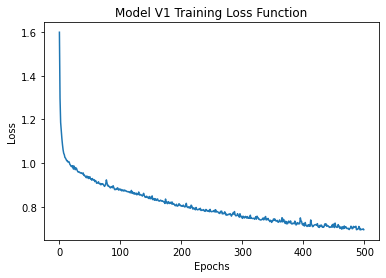

In [23]:
# Plot the loss over epochs

plt.plot(model_v1.history["loss"])
plt.title("Model V1 Training Loss Function")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

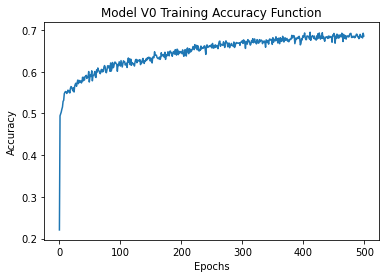

In [24]:
# Plot the accuracy over epochs

plt.plot(model_v1.history["accuracy"])
plt.title("Model V0 Training Accuracy Function")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [25]:
model_loss, model_accuracy = nn_v1.evaluate(
    X_test, y_test, verbose=2
)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

19/19 - 0s - loss: 2.6006 - accuracy: 0.4983 - 168ms/epoch - 9ms/step
Loss: 2.60064435005188, Accuracy: 0.4982876777648926


In [26]:

y_pred = nn_v1.predict(X_test)
pred_final = np.argmax(y_pred, axis=1)

y_test_reverted = []
for lists in y_test:
    if lists[0] == 1:
        y_test_reverted.append('CH')
    elif lists[1] == 1:
        y_test_reverted.append('CU')
    elif lists[2] == 1:
        y_test_reverted.append('FF')
    else:
        y_test_reverted.append('SL')

y_pred_converted = []
for numbers in pred_final:
    if numbers == 0:
        y_pred_converted.append('CH')
    elif numbers == 1:
        y_pred_converted.append('CU')
    elif numbers == 2:
        y_pred_converted.append('FF')
    else: 
        y_pred_converted.append('SL')

# display(y_test)
# display(pred_final)
final_results_v1 = pd.DataFrame({
    'Predictions': y_pred_converted,
    'Actual':  y_test_reverted})

display(final_results_v1.head())
print(classification_report(final_results['Actual'], final_results['Predictions']))

19/19 [==============================] - 0s 698us/step


,Predictions,Actual
0,FF,FF
1,FF,FF
2,FF,FF
3,SL,FF
4,FF,CU


              precision    recall  f1-score   support

          CH       0.00      0.00      0.00         8
          CU       0.35      0.25      0.29       120
          FF       0.61      0.65      0.63       292
          SL       0.46      0.51      0.48       164

    accuracy                           0.52       584
   macro avg       0.35      0.35      0.35       584
weighted avg       0.50      0.52      0.51       584



/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Optimized Model 2

From Keras, use the stochastic gradient descent (SGD) optimizer that is an iterative method for optimizing an objective function with suitable smoothness properties

In [27]:
# Define the model

nn_v2 = Sequential()

In [28]:
# Design the network architecture 

import tensorflow as tf

tf.keras.optimizers.Adadelta()
#from keras.optimizers import Adadelta
# Define the model - deep neural net

total_neurons = len(X.columns)*(2/3)
number_input_features = len(X.columns)
number_output = 4

# Define hidden layers
i = 0
hidden_nodes_layer=(number_input_features+number_output)/2
while hidden_nodes_layer/2 > 4: 
    if i == 0:
        nn_v2.add(Dense(units=round(hidden_nodes_layer), input_dim=number_input_features, activation='relu'))
        i+=1
    else:
        hidden_nodes_layer = hidden_nodes_layer/2
        nn_v2.add(Dense(units=round(hidden_nodes_layer), activation='relu'))
        i+=1

# Define output layer
nn_v2.add(Dense(units=number_output, activation='softmax'))

# Compile the model
nn_v2.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

display(nn_v2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 26)                1300      
                                                                 
 dense_9 (Dense)             (None, 13)                351       
                                                                 
 dense_10 (Dense)            (None, 7)                 98        
                                                                 
 dense_11 (Dense)            (None, 4)                 32        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


None

In [29]:
# Fit the data to the model

model_v2 = nn_v2.fit(X_train, y_train, epochs=100)

Epoch 1/100
55/55 [==============================] - 0s 786us/step - loss: 2.3854 - accuracy: 0.0417
Epoch 2/100
55/55 [==============================] - 0s 787us/step - loss: 2.3717 - accuracy: 0.0422
Epoch 3/100
55/55 [==============================] - 0s 776us/step - loss: 2.3575 - accuracy: 0.0428
Epoch 4/100
55/55 [==============================] - 0s 778us/step - loss: 2.3429 - accuracy: 0.0428
Epoch 5/100
55/55 [==============================] - 0s 799us/step - loss: 2.3279 - accuracy: 0.0422
Epoch 6/100
55/55 [==============================] - 0s 771us/step - loss: 2.3125 - accuracy: 0.0428
Epoch 7/100
55/55 [==============================] - 0s 771us/step - loss: 2.2967 - accuracy: 0.0439
Epoch 8/100
55/55 [==============================] - 0s 798us/step - loss: 2.2807 - accuracy: 0.0439
Epoch 9/100
55/55 [==============================] - 0s 791us/step - loss: 2.2643 - accuracy: 0.0445
Epoch 10/100
55/55 [==============================] - 0s 766us/step - loss: 2.2477 - accura

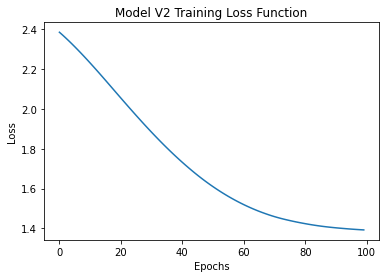

In [30]:
# Plot the loss over epochs

plt.plot(model_v2.history["loss"])
plt.title("Model V2 Training Loss Function")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

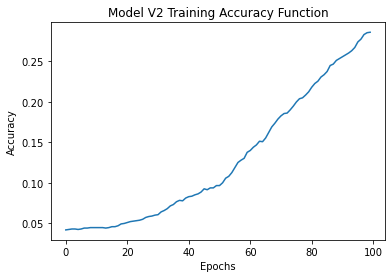

In [31]:
# Plot the accuracy over epochs

plt.plot(model_v2.history["accuracy"])
plt.title("Model V2 Training Accuracy Function")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [32]:
model_loss, model_accuracy = nn_v2.evaluate(
    X_test, y_test, verbose=2
)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

19/19 - 0s - loss: 1.3952 - accuracy: 0.2911 - 112ms/epoch - 6ms/step
Loss: 1.3952271938323975, Accuracy: 0.29109588265419006


In [33]:

y_pred = nn_v2.predict(X_test)
pred_final = np.argmax(y_pred, axis=1)

y_test_reverted = []
for lists in y_test:
    if lists[0] == 1:
        y_test_reverted.append('CH')
    elif lists[1] == 1:
        y_test_reverted.append('CU')
    elif lists[2] == 1:
        y_test_reverted.append('FF')
    else:
        y_test_reverted.append('SL')

y_pred_converted = []
for numbers in pred_final:
    if numbers == 0:
        y_pred_converted.append('CH')
    elif numbers == 1:
        y_pred_converted.append('CU')
    elif numbers == 2:
        y_pred_converted.append('FF')
    else: 
        y_pred_converted.append('SL')

# display(y_test)
# display(pred_final)
final_results_v2 = pd.DataFrame({
    'Predictions': y_pred_converted,
    'Actual':  y_test_reverted})

display(final_results_v2.head())
print(classification_report(final_results['Actual'], final_results['Predictions']))

19/19 [==============================] - 0s 673us/step


,Predictions,Actual
0,SL,FF
1,SL,FF
2,FF,FF
3,SL,FF
4,FF,CU


              precision    recall  f1-score   support

          CH       0.00      0.00      0.00         8
          CU       0.35      0.25      0.29       120
          FF       0.61      0.65      0.63       292
          SL       0.46      0.51      0.48       164

    accuracy                           0.52       584
   macro avg       0.35      0.35      0.35       584
weighted avg       0.50      0.52      0.51       584



/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Optimized Model 3

From Keras, use the stochastic gradient descent (SGD) optimizer that is an iterative method for optimizing an objective function with suitable smoothness properties

In [34]:
# Define the model

nn_v3 = Sequential()

In [35]:
# Design the network architecture 


from keras.optimizers import SGD
# Define the model - deep neural net

total_neurons = len(X.columns)*(2/3)
number_input_features = len(X.columns)
number_output = 4

# Define hidden layers
i = 0
hidden_nodes_layer=(number_input_features+number_output)/2
while hidden_nodes_layer/2 > 4: 
    if i == 0:
        nn_v3.add(Dense(units=round(hidden_nodes_layer), input_dim=number_input_features, activation='relu'))
        i+=1
    else:
        hidden_nodes_layer = hidden_nodes_layer/2
        nn_v3.add(Dense(units=round(hidden_nodes_layer), activation='relu'))
        i+=1

# Define output layer
nn_v3.add(Dense(units=number_output, activation='softmax'))

# Compile the model
nn_v3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

display(nn_v3.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 26)                1300      
                                                                 
 dense_13 (Dense)            (None, 13)                351       
                                                                 
 dense_14 (Dense)            (None, 7)                 98        
                                                                 
 dense_15 (Dense)            (None, 4)                 32        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


None

In [36]:
# Fit the data to the model

model_v3 = nn_v3.fit(X_train, y_train, epochs=100)

Epoch 1/100
55/55 [==============================] - 0s 783us/step - loss: 1.4886 - accuracy: 0.4532
Epoch 2/100
55/55 [==============================] - 0s 759us/step - loss: 1.3057 - accuracy: 0.4909
Epoch 3/100
55/55 [==============================] - 0s 738us/step - loss: 1.2661 - accuracy: 0.5040
Epoch 4/100
55/55 [==============================] - 0s 751us/step - loss: 1.2363 - accuracy: 0.5074
Epoch 5/100
55/55 [==============================] - 0s 763us/step - loss: 1.2136 - accuracy: 0.5074
Epoch 6/100
55/55 [==============================] - 0s 755us/step - loss: 1.1962 - accuracy: 0.5074
Epoch 7/100
55/55 [==============================] - 0s 767us/step - loss: 1.1825 - accuracy: 0.5074
Epoch 8/100
55/55 [==============================] - 0s 748us/step - loss: 1.1717 - accuracy: 0.5074
Epoch 9/100
55/55 [==============================] - 0s 756us/step - loss: 1.1631 - accuracy: 0.5051
Epoch 10/100
55/55 [==============================] - 0s 746us/step - loss: 1.1543 - accura

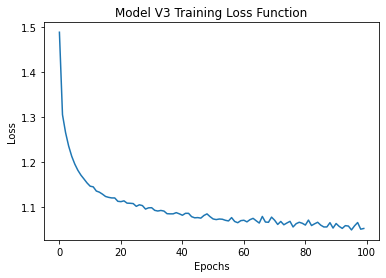

In [37]:
# Plot the loss over epochs

plt.plot(model_v3.history["loss"])
plt.title("Model V3 Training Loss Function")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

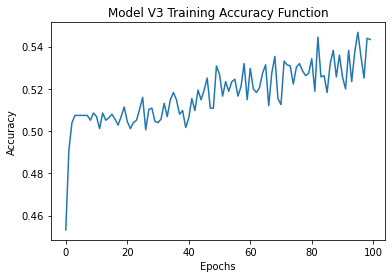

In [38]:
# Plot the accuracy over epochs

plt.plot(model_v3.history["accuracy"])
plt.title("Model V3 Training Accuracy Function")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [39]:
model_loss, model_accuracy = nn_v3.evaluate(
    X_test, y_test, verbose=2
)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

19/19 - 0s - loss: 1.0563 - accuracy: 0.5086 - 119ms/epoch - 6ms/step
Loss: 1.0563043355941772, Accuracy: 0.5085616707801819


In [40]:

y_pred = nn_v3.predict(X_test)
pred_final = np.argmax(y_pred, axis=1)

y_test_reverted = []
for lists in y_test:
    if lists[0] == 1:
        y_test_reverted.append('CH')
    elif lists[1] == 1:
        y_test_reverted.append('CU')
    elif lists[2] == 1:
        y_test_reverted.append('FF')
    else:
        y_test_reverted.append('SL')

y_pred_converted = []
for numbers in pred_final:
    if numbers == 0:
        y_pred_converted.append('CH')
    elif numbers == 1:
        y_pred_converted.append('CU')
    elif numbers == 2:
        y_pred_converted.append('FF')
    else: 
        y_pred_converted.append('SL')

# display(y_test)
# display(pred_final)
final_results_v3 = pd.DataFrame({
    'Predictions': y_pred_converted,
    'Actual':  y_test_reverted})

display(final_results_v3.head())
print(classification_report(final_results['Actual'], final_results['Predictions']))

19/19 [==============================] - 0s 750us/step


,Predictions,Actual
0,FF,FF
1,SL,FF
2,FF,FF
3,FF,FF
4,FF,CU


              precision    recall  f1-score   support

          CH       0.00      0.00      0.00         8
          CU       0.35      0.25      0.29       120
          FF       0.61      0.65      0.63       292
          SL       0.46      0.51      0.48       164

    accuracy                           0.52       584
   macro avg       0.35      0.35      0.35       584
weighted avg       0.50      0.52      0.51       584



/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
